<h1 align=center><b>History based Wikipedia page recommender<b></h1>

# Get a document collection 

In [1]:
import requests
import bs4
import re
import random
import matplotlib.pyplot as plt
import networkx as nx
# from time import sleep

The approach for collecting data is to use BFS to traverse `N` random links from the current URL and process only a fixed number of documents.

In [2]:
def bfs(url):
    queue = []
    visited = dict()
    
    graph = nx.Graph()
    links = []
    
    counter = 0
    stopper = 30
    neighboursN = 10
    
    queue.append(url)
    visited[url] = True
    
    while (all((len(queue) > 0, counter <= stopper))): # stop after processing 'stopper' links
        current = queue.pop(0)
        # sleep(random.random())
        # Get and parse a page
        response = requests.get(current)
        if (response.status_code != 200):
            raise Exception("Failed to get the page")
        parsed = bs4.BeautifulSoup(response.text)
        
        links.append(current)
        counter += 1
        
        neighbours = parsed.find(id = "bodyContent").find_all('a', attrs={'href': re.compile(r'^/wiki/')})
        random.shuffle(neighbours)
        for link in neighbours[:neighboursN]: # traverse only 'neighboursN' neighbours
            nextURL = "https://en.wikipedia.org" + link['href']
            if (not nextURL in visited):
                queue.append(nextURL)
                visited[nextURL] = True
                graph.add_edge(current, nextURL)
    return links, graph

In [3]:
startURL = "https://en.wikipedia.org/wiki/Artificial_intelligence"

Below are the first several URLs from our colection and the web structure of visited docs.

CPU times: user 4.44 s, sys: 49.7 ms, total: 4.49 s
Wall time: 9.76 s
https://en.wikipedia.org/wiki/Artificial_intelligence
https://en.wikipedia.org/wiki/Productivity
https://en.wikipedia.org/wiki/S2CID_(identifier)
https://en.wikipedia.org/wiki/Decision_analysis
https://en.wikipedia.org/wiki/Information_and_communications_technology


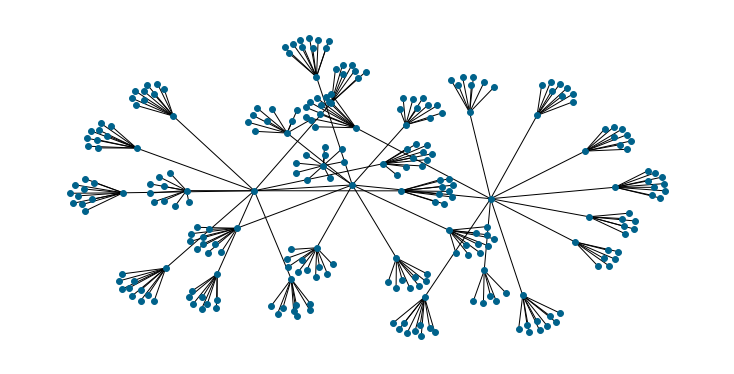

In [4]:
%time links, graph = bfs(startURL)
print(*links[:5], sep='\n')
plt.figure(figsize=(10,5)) 
nx.draw(graph, node_size=35, node_color='#00628b')

In [5]:
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [6]:
def getText(url):
    response = requests.get(url)
    if (response.status_code != 200):
        raise Exception("Failed to get the page")
    parsed = bs4.BeautifulSoup(response.text)
    output = ''.join(p.getText() for p in parsed.select('p'))
    return output.strip('\n')

In [7]:
text = getText(startURL)
text[:500]

'Artificial intelligence (AI) is intelligence - perceiving, synthesizing, and infering information - demonstrated by machines, as opposed to intelligence displayed by animals and humans. Example tasks in which this is done include speech recognition, computer vision, translation between (natural) languages, as well as other mappings of inputs.  OED (OUP) defines artificial intelligence as:[1]\nthe theory and development of computer systems able to perform tasks that normally require human intellig'

For preprocessing texts stop-word and punctuation elimination, tokenization and lemmatization methods are applied. Additionally, tokens, which contain less that 3 symbols or/and digits are excluded.

In [8]:
def preprocessText(text):
    stopWords = stopwords.words('english')
    wordnet = WordNetLemmatizer()
    processed = []
    for t in word_tokenize(text):
        if (
            (t not in stopWords) and # exclude stop-words
            (t not in punctuation) and # exclude punctuation
            (len(t) > 2) and # don't process tokens of size < 3
            (not any(char.isdigit() for char in t)) # don't process tokens containing digits
        ):
            processed.append(wordnet.lemmatize(t.lower())) # lemmatization
    processed = ' '.join(processed)
    return processed

In [9]:
text = preprocessText(text)
text[:500]

'artificial intelligence intelligence perceiving synthesizing infering information demonstrated machine opposed intelligence displayed animal human example task done include speech recognition computer vision translation natural language well mapping input oed oup defines artificial intelligence theory development computer system able perform task normally require human intelligence visual perception speech recognition decision-making translation language application include advanced web search e'

# Get recommendations

In [10]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
from scipy.spatial.distance import cosine
from functools import reduce

In [11]:
texts = []
for link in links:
    text = getText(link)
    text = preprocessText(text)
    texts.append(text)

The underlying technique for working with documents of our recommendation system is TF-IDF. 

In [12]:
tfidf = TfidfVectorizer(use_idf=True, smooth_idf=False)
documentTFIDFsDF = pd.DataFrame(tfidf.fit_transform(texts).toarray(), 
                                index = links, 
                                columns = tfidf.get_feature_names_out())
documentTFIDFsDF.head()

,aaai,aadhar,aams,abandoned,abbasid,abbreviated,abbreviation,abet,ability,able,...,zpp,zuckerberg,zuihitsu,émile,örebro,čapek,œuvres,τmax,τmin,八股文
https://en.wikipedia.org/wiki/Artificial_intelligence,0.007136,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.042600,0.020582,...,0.0,0.007136,0.0,0.0,0.0,0.014272,0.0,0.0,0.0,0.0
https://en.wikipedia.org/wiki/Productivity,0.000000,0.0,0.0,0.011055,0.0,0.000000,0.000000,0.0,0.042119,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
https://en.wikipedia.org/wiki/S2CID_(identifier),0.000000,0.0,0.0,0.000000,0.0,0.039397,0.000000,0.0,0.018091,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
https://en.wikipedia.org/wiki/Decision_analysis,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
https://en.wikipedia.org/wiki/Information_and_communications_technology,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.012315,0.0,0.011310,0.005920,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [13]:
history = [
    "https://en.wikipedia.org/wiki/Computer", 
    "https://en.wikipedia.org/wiki/Computer_science", 
    "https://en.wikipedia.org/wiki/Google"
]
# Parse history
historyTexts = []
for link in history:
    text = getText(link)
    text = preprocessText(text)
    historyTexts.append(text)

Firstly, we compute TF-IDF for both history and database docs. Secondly, for every doc in the history we find cosine similarities with docs from the DB in the TF-IDF space. Thirdly, the similarities are summed and sorted in descending order. The **top k** document links are returned.

Also, this function returns the `mostSimilar` DataFrame, which shows for every history doc the most similar (diffrent) doc from the DB and the respective similarity value.  

In [14]:
def recommend(historyLinks, historyTexts, dbLinks, dbTexts, k):
    # Get TF-IDFs of history documents and database
    tfidf = TfidfVectorizer(use_idf=True, smooth_idf=False)
    documentTFIDFsDF = pd.DataFrame(tfidf.fit_transform(historyTexts + dbTexts).toarray(), 
                           index = historyLinks + dbLinks, 
                           columns = tfidf.get_feature_names_out())
    # split TF-IDFs
    historyTFIDFs = documentTFIDFsDF.iloc[:len(historyLinks)]
    dbTFIDFs = documentTFIDFsDF.iloc[len(historyLinks):]
    
    # For every query in history compute cos similarities with DB
    mostSimilar = [[], []]
    similarities = []
    for i in range(len(historyLinks)):
        q = historyTFIDFs.iloc[i].to_numpy()
        sim = (1-dbTFIDFs.apply(lambda x: cosine(x, q), axis=1)).to_frame()
        similarities.append(sim)
        # Sort similarities, store the closest one's name and value
        sortedSim = sim.sort_values(by=[0], ascending=False)
        for i in range(len(sortedSim)):
            doc = sortedSim.iloc[i].name
            if (doc not in historyLinks):
                mostSimilar[0].append(doc)
                mostSimilar[1].append(sortedSim.iloc[i].to_numpy()[0])
                break
        
    mostSimilar = pd.DataFrame(zip(historyLinks, mostSimilar[0], mostSimilar[1]), columns = ["History doc", "Most similar doc", "Similarity"]) 
    # Sum and sort them, return `k` closest, which are not in history
    similarities = reduce(pd.DataFrame.add, similarities)
    counter = 0
    recommenations = []
    for doc in list(similarities.sort_values(by=[0], ascending=False).index):
        if (doc not in history):
            recommenations.append(doc)
            counter += 1
        if (counter == k):
            break
    return recommenations, mostSimilar

In [15]:
recommendations, mostSimilar = recommend(history, historyTexts, links, texts, 5)
print(*recommendations, sep = '\n')
mostSimilar.style

https://en.wikipedia.org/wiki/Artificial_intelligence
https://en.wikipedia.org/wiki/Engineering
https://en.wikipedia.org/wiki/AI_accelerator
https://en.wikipedia.org/wiki/Intractability_(complexity)
https://en.wikipedia.org/wiki/Information_and_communications_technology


,History doc,Most similar doc,Similarity
0,https://en.wikipedia.org/wiki/Computer,https://en.wikipedia.org/wiki/Artificial_intelligence,0.272486
1,https://en.wikipedia.org/wiki/Computer_science,https://en.wikipedia.org/wiki/Engineering,0.316867
2,https://en.wikipedia.org/wiki/Google,https://en.wikipedia.org/wiki/Artificial_intelligence,0.166381


# Construct database

In [16]:
import os

Here two functions are combined (for computational efficiency): `bfs()` and `getText()` to create a database of documents and store them as files with names exctacted from URLs and texts in the contents.

In [17]:
# bfs + getText
def retrieveDocuments(url):
    queue = []
    visited = dict()
    
    stopWords = stopwords.words('english')
    wordnet = WordNetLemmatizer()
    
    counter = 0
    stopper = 350
    neighboursN = 10
    
    queue.append(url)
    visited[url] = True
    
    while ((len(queue) > 0) and (counter < stopper)): # stop after processing 'stopper' links
        current = queue.pop(0)
        documentPath = "./database/" + current.split('/')[-1] + ".txt"
        if (os.path.exists(documentPath)): # check if the doc is already in the DB
            continue
        # Get and parse a page
        response = requests.get(current)
        if (response.status_code != 200):
            raise Exception("Failed to get the page")
        parsed = bs4.BeautifulSoup(response.text)
        # Extract the text
        text = ''.join(p.getText() for p in parsed.select('p')).strip('\n').replace('\n', ' ')
        if (not text): # check if there is any text
            continue
        # Store the document
        with open(documentPath, "w+") as f:
            f.write(current + '\n' + text)
        counter += 1
    
        neighbours = parsed.find(id = "bodyContent").find_all('a', attrs={'href': re.compile(r'^/wiki/')})
        random.shuffle(neighbours)
        for link in neighbours[:neighboursN]: # traverse only 'neighboursN' neighbours
            nextURL = "https://en.wikipedia.org" + link['href']
            if (not nextURL in visited):
                queue.append(nextURL)
                visited[nextURL] = True

In [18]:
startURL = "https://en.wikipedia.org/wiki/Artificial_intelligence"
%time retrieveDocuments(startURL)

CPU times: user 1min 6s, sys: 523 ms, total: 1min 7s
Wall time: 2min 8s


In [19]:
startURL = "https://en.wikipedia.org/wiki/Apple_Inc."
%time retrieveDocuments(startURL)

CPU times: user 1min 6s, sys: 534 ms, total: 1min 6s
Wall time: 2min 20s


In [20]:
startURL = "https://en.wikipedia.org/wiki/Information"
%time retrieveDocuments(startURL)

CPU times: user 1min 7s, sys: 480 ms, total: 1min 8s
Wall time: 2min 21s


# Read the Database and recommend 

In [21]:
def readDataBase(directory):
    dbLinks, dbTexts = [], []

    for doc in os.listdir(directory):
        with open(directory + '/' + doc, 'r') as f:
            dbLinks.append(f.readline().strip('\n'))
            dbTexts.append(f.read())
    return dbLinks, dbTexts

Our database consists of 1050 distinct documents with **unprocessed** text. The most frequent terms are shown below.

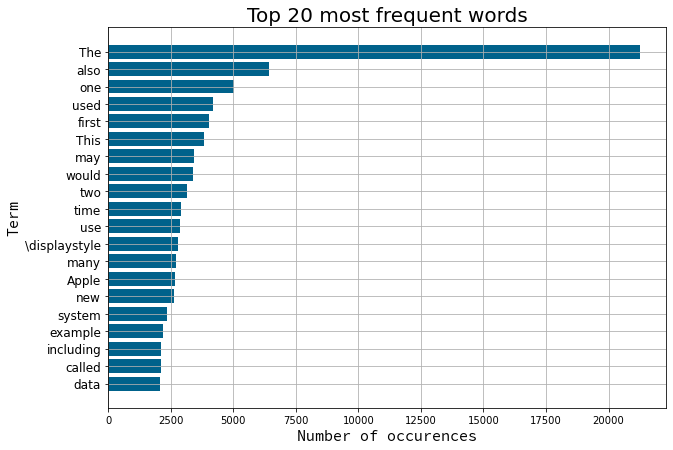

In [22]:
# Read the Database
dbLinks, dbTexts = readDataBase("database")
# Count occurences of terms
termCount = dict()
stopWords = stopwords.words('english')
for text in dbTexts:
    for t in word_tokenize(text):
        if (
            (t not in stopWords) and # exclude stop-words
            (t not in punctuation) and # exclude punctuation
            (len(t) > 2) and # don't process tokens of size < 3
            (not any(char.isdigit() for char in t)) # don't process tokens containing digits
        ):
            if t in termCount:
                termCount[t] += 1
            else:
                termCount[t] = 1
# Sort them
termCount = dict(sorted(termCount.items(), key = lambda item: item[1], reverse=True))
# Plot top `k` most frequent
k = 20
plt.figure(figsize=(10,7)) 
plt.barh(list(termCount.keys())[k-1::-1], 
         list(termCount.values())[k-1::-1], 
         color = '#00628b')

plt.title(f"Top {k} most frequent words", fontdict = {'size':20})
font = {'family': 'source code pro','size': 15}
plt.xlabel("Number of occurences", fontdict = font)
plt.xticks(fontsize=10)
plt.ylabel("Term", fontdict = font)
plt.yticks(fontsize=12)

plt.grid()
plt.show() 

Finally, after loading the DB, we can preprocess it, parse the history and get the recommendations.

In [23]:
# Preprocess the DB
for i in range(len(dbTexts)):
    dbTexts[i] = preprocessText(dbTexts[i])

In [24]:
history = [
    "https://en.wikipedia.org/wiki/Computer", 
    "https://en.wikipedia.org/wiki/Computer_science", 
    "https://en.wikipedia.org/wiki/Google"
]

# Parse history
historyTexts = []
for link in history:
    historyTexts.append(preprocessText(getText(link)))
# Get recommendations
recommendations, mostSimilar = recommend(history, historyTexts, dbLinks, dbTexts, 5)
for i in range(len(recommendations)):
    print(f"{i+1}. {recommendations[i]}")
mostSimilar.style

1. https://en.wikipedia.org/wiki/Human-Computer_Interaction
2. https://en.wikipedia.org/wiki/Computer_programming
3. https://en.wikipedia.org/wiki/Computer_vision
4. https://en.wikipedia.org/wiki/Philosophy_of_computer_science
5. https://en.wikipedia.org/wiki/Artificial_intelligence


,History doc,Most similar doc,Similarity
0,https://en.wikipedia.org/wiki/Computer,https://en.wikipedia.org/wiki/Computer_programming,0.409518
1,https://en.wikipedia.org/wiki/Computer_science,https://en.wikipedia.org/wiki/Philosophy_of_computer_science,0.435166
2,https://en.wikipedia.org/wiki/Google,https://en.wikipedia.org/wiki/Google_Web_Designer,0.459257
